<a href="https://colab.research.google.com/github/duwi27sulis/Peramalan-LSTM_75-25/blob/main/Revnb_75_25_Update_H1_T12_Fix_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.7 MB/s eta 0:00:00


In [8]:
# Package
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import optuna
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [9]:
# Fix random seed for reproducibility
tf.random.set_seed(10)
plt.rcParams['figure.figsize'] = (12,6)

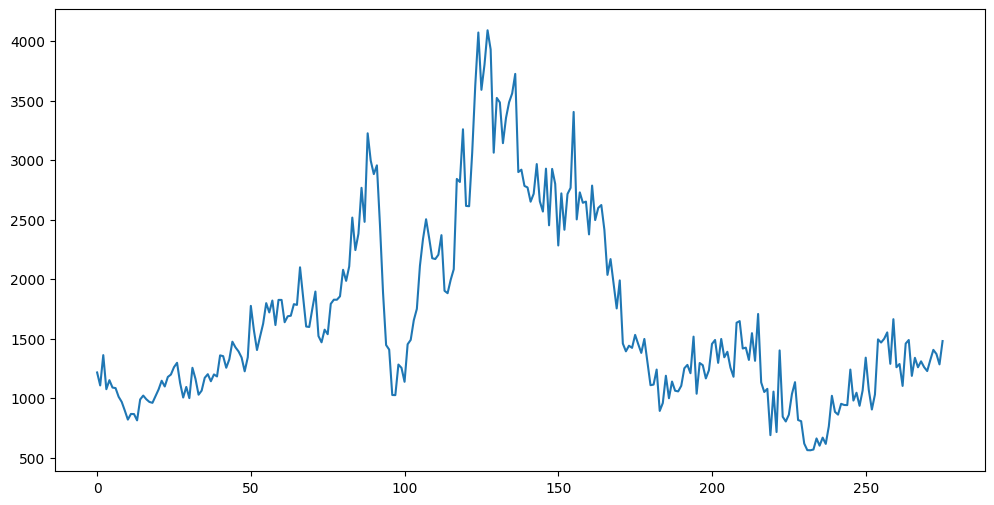

In [10]:
# Input Data
url = "https://raw.githubusercontent.com/duwi27sulis/Analisis_Data_LSTM/main/Ekspor-Migas-2001-2023.csv"
df = pd.read_csv(url, sep=",")
df['Tanggal'] = pd.to_datetime(df.Tanggal)
dataframe = pd.read_csv(url, usecols=[1], engine='python')
dataset = dataframe.values.astype('float32')
plt.plot(dataset)

In [11]:
# Pembagian data
#train_size = int(len(dataset)*0.75)
train_size = 207
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [12]:
time_steps = 12
last_row_train = train[-time_steps:]
test = np.concatenate([last_row_train, test], axis=0)

In [13]:
ytest = test
ytrain = train

In [14]:
# Normalisasi Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit(dataset)

train = scaled_data.transform(train)
test = scaled_data.transform(test)

In [15]:
# Fungsi untuk membuat dataset
def create_dataset (X, y, time_steps = time_steps):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

In [16]:
X_test, y_test = create_dataset(test, test)
X_train, y_train = create_dataset(train, train)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (195, 12, 1)
y_train.shape:  (195, 1)
X_test.shape:  (69, 12, 1)
y_test.shape:  (69, 1)


In [17]:
# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [18]:
# Define early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=20)

In [19]:
def objective(trial):
    # Define the search space
    lstm_units = trial.suggest_categorical('lstm_units', [32, 64, 128])
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.1, 0.2, 0.3, 0.4, 0.5])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = trial.suggest_int('epochs', 50, 200, 50)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])

    # Cross-validation scores
    cv_scores = []

    for fold_index, (train_index, val_index) in enumerate(tscv.split(X_train)):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Build the model
        model = Sequential([
            LSTM(units=lstm_units, input_shape=(X_train_fold.shape[1], 1)),
            Dropout(dropout_rate),
            Dense(1)
        ])

        # Select optimizer
        if optimizer_name == 'Adam':
            optimizer = Adam(learning_rate=learning_rate)
        elif optimizer_name == 'RMSprop':
            optimizer = RMSprop(learning_rate=learning_rate)
        else:
            optimizer = SGD(learning_rate=learning_rate)

        model.compile(optimizer=optimizer, loss='mse')

        # Fit the model
        history = model.fit(X_train_fold, y_train_fold,
                            validation_data=(X_val_fold, y_val_fold),
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[early_stopping],
                            verbose=0)

        # Evaluate the model
        val_pred = model.predict(X_val_fold)
        mse = mean_squared_error(y_val_fold, val_pred)
        cv_scores.append(mse)

        # Print MSE for each fold
        print(f"Fold {fold_index + 1}: MSE = {mse:.4f}")

    # Print average MSE across all folds
    print(f"Average MSE: {np.mean(cv_scores):.4f}")

    return np.mean(cv_scores)

In [20]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best parameters
print('Best parameters:', study.best_params)
print('Best value:', study.best_value)

[I 2024-08-13 08:52:21,608] A new study created in memory with name: no-name-27244117-d392-4712-af48-71711ef04de8


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Fold 1: MSE = 0.9740
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 2: MSE = 0.0773
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Fold 3: MSE = 0.2776
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Fold 4: MSE = 0.0344


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


[I 2024-08-13 08:52:51,270] Trial 0 finished with value: 0.27310293912887573 and parameters: {'lstm_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.27310293912887573.


Fold 5: MSE = 0.0021
Average MSE: 0.2731


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 1: MSE = 0.0177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 2: MSE = 0.0562
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Fold 3: MSE = 0.1313
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Fold 4: MSE = 0.0503
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-08-13 08:53:08,717] Trial 1 finished with value: 0.05250280350446701 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.05250280350446701.


Fold 5: MSE = 0.0070
Average MSE: 0.0525
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 1: MSE = 0.0849
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 2: MSE = 0.1681
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Fold 3: MSE = 0.4538
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Fold 4: MSE = 0.1207
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


[I 2024-08-13 08:53:25,842] Trial 2 finished with value: 0.16615018248558044 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.05250280350446701.


Fold 5: MSE = 0.0033
Average MSE: 0.1662
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
Fold 1: MSE = 0.0422
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Fold 2: MSE = 0.0770
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Fold 3: MSE = 0.3038
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Fold 4: MSE = 0.0328
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-08-13 08:53:40,341] Trial 3 finished with value: 0.09375842660665512 and parameters: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.05250280350446701.


Fold 5: MSE = 0.0131
Average MSE: 0.0938
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
Fold 1: MSE = 0.1069
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 2: MSE = 0.2443
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 3: MSE = 0.3700
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Fold 4: MSE = 0.2398
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


[I 2024-08-13 08:53:56,516] Trial 4 finished with value: 0.1936110556125641 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.05250280350446701.


Fold 5: MSE = 0.0071
Average MSE: 0.1936
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 1: MSE = 0.0244
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Fold 2: MSE = 7.2279
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Fold 3: MSE = 3.8630
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Fold 4: MSE = 2.7872
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


[I 2024-08-13 08:54:23,960] Trial 5 finished with value: 4.3917107582092285 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.05250280350446701.


Fold 5: MSE = 8.0561
Average MSE: 4.3917
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Fold 1: MSE = 0.0155
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
Fold 2: MSE = 0.0295
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 3: MSE = 0.0538
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 4: MSE = 0.0136
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


[I 2024-08-13 08:54:50,243] Trial 6 finished with value: 0.022962696850299835 and parameters: {'lstm_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.022962696850299835.


Fold 5: MSE = 0.0024
Average MSE: 0.0230
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Fold 1: MSE = 0.0234
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Fold 2: MSE = 0.0445
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Fold 3: MSE = 0.0871
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Fold 4: MSE = 0.0220
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


[I 2024-08-13 08:55:10,829] Trial 7 finished with value: 0.03748998045921326 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 200, 'optimizer': 'SGD'}. Best is trial 6 with value: 0.022962696850299835.


Fold 5: MSE = 0.0103
Average MSE: 0.0375
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Fold 1: MSE = 0.0244
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Fold 2: MSE = 0.0398
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 3: MSE = 0.1680
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 4: MSE = 0.0247
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-08-13 08:55:27,598] Trial 8 finished with value: 0.053341370075941086 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 200, 'optimizer': 'SGD'}. Best is trial 6 with value: 0.022962696850299835.


Fold 5: MSE = 0.0098
Average MSE: 0.0533
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 1: MSE = 0.0316
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 2: MSE = 0.0582
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 3: MSE = 0.0335
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Fold 4: MSE = 0.0250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


[I 2024-08-13 08:55:47,951] Trial 9 finished with value: 0.030143756419420242 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 6 with value: 0.022962696850299835.


Fold 5: MSE = 0.0024
Average MSE: 0.0301
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Fold 1: MSE = 0.0151
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Fold 2: MSE = 0.0270
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Fold 3: MSE = 0.0530
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 4: MSE = 0.0184
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


[I 2024-08-13 08:56:10,105] Trial 10 finished with value: 0.023182962089776993 and parameters: {'lstm_units': 32, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.022962696850299835.


Fold 5: MSE = 0.0024
Average MSE: 0.0232
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 1: MSE = 0.0136
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Fold 2: MSE = 0.0308
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Fold 3: MSE = 0.0752
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Fold 4: MSE = 0.0368
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


[I 2024-08-13 08:56:32,362] Trial 11 finished with value: 0.03263049200177193 and parameters: {'lstm_units': 32, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.022962696850299835.


Fold 5: MSE = 0.0068
Average MSE: 0.0326
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Fold 1: MSE = 0.0136
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Fold 2: MSE = 0.0306
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Fold 3: MSE = 0.0638
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Fold 4: MSE = 0.0260
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


[I 2024-08-13 08:56:54,657] Trial 12 finished with value: 0.027234148234128952 and parameters: {'lstm_units': 32, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.022962696850299835.


Fold 5: MSE = 0.0021
Average MSE: 0.0272
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Fold 1: MSE = 0.0134
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Fold 2: MSE = 0.0245
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 3: MSE = 0.0478
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 4: MSE = 0.0229
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


[I 2024-08-13 08:57:15,850] Trial 13 finished with value: 0.022167455404996872 and parameters: {'lstm_units': 32, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.022167455404996872.


Fold 5: MSE = 0.0021
Average MSE: 0.0222
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Fold 1: MSE = 0.0156
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 2: MSE = 0.0269
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Fold 3: MSE = 0.0430
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
Fold 4: MSE = 0.0115
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


[I 2024-08-13 08:57:41,854] Trial 14 finished with value: 0.019768759608268738 and parameters: {'lstm_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 14 with value: 0.019768759608268738.


Fold 5: MSE = 0.0018
Average MSE: 0.0198
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Fold 1: MSE = 0.0261
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Fold 2: MSE = 0.0506
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Fold 3: MSE = 0.0306
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Fold 4: MSE = 0.0440
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


[I 2024-08-13 08:58:06,324] Trial 15 finished with value: 0.034981273114681244 and parameters: {'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 14 with value: 0.019768759608268738.


Fold 5: MSE = 0.0237
Average MSE: 0.0350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Fold 1: MSE = 0.0097
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
Fold 2: MSE = 0.0222
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 3: MSE = 0.0211
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Fold 4: MSE = 0.0066
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-08-13 08:58:27,868] Trial 16 finished with value: 0.012447899207472801 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 16 with value: 0.012447899207472801.


Fold 5: MSE = 0.0027
Average MSE: 0.0124
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 1: MSE = 0.0095
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Fold 2: MSE = 0.0243
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
Fold 3: MSE = 0.0209
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 4: MSE = 0.0085
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


[I 2024-08-13 08:58:52,785] Trial 17 finished with value: 0.013035958632826805 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 16 with value: 0.012447899207472801.


Fold 5: MSE = 0.0019
Average MSE: 0.0130
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 1: MSE = 0.0185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Fold 2: MSE = 0.0366
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 3: MSE = 0.0290
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 4: MSE = 0.0118
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


[I 2024-08-13 08:59:14,638] Trial 18 finished with value: 0.020478056743741035 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 16 with value: 0.012447899207472801.


Fold 5: MSE = 0.0065
Average MSE: 0.0205
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 1: MSE = 0.0129
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
Fold 2: MSE = 0.0243
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Fold 3: MSE = 0.0120
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Fold 4: MSE = 0.0312
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


[I 2024-08-13 08:59:34,686] Trial 19 finished with value: 0.016417639330029488 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 16 with value: 0.012447899207472801.


Fold 5: MSE = 0.0017
Average MSE: 0.0164
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Fold 1: MSE = 0.0112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Fold 2: MSE = 0.0239
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
Fold 3: MSE = 0.0173
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Fold 4: MSE = 0.0075
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


[I 2024-08-13 08:59:59,528] Trial 20 finished with value: 0.012308484874665737 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.012308484874665737.


Fold 5: MSE = 0.0017
Average MSE: 0.0123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 1: MSE = 0.0096
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Fold 2: MSE = 0.0279
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Fold 3: MSE = 0.0146
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Fold 4: MSE = 0.0074
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2024-08-13 09:00:22,754] Trial 21 finished with value: 0.012311563827097416 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.012308484874665737.


Fold 5: MSE = 0.0021
Average MSE: 0.0123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 1: MSE = 0.0153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 2: MSE = 0.0251
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Fold 3: MSE = 0.0155
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 4: MSE = 0.0072
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2024-08-13 09:00:44,579] Trial 22 finished with value: 0.012946687638759613 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.012308484874665737.


Fold 5: MSE = 0.0018
Average MSE: 0.0129
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Fold 1: MSE = 0.0130
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 2: MSE = 0.0225
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Fold 3: MSE = 0.0209
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Fold 4: MSE = 0.0067
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


[I 2024-08-13 09:01:05,389] Trial 23 finished with value: 0.013031169772148132 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 20 with value: 0.012308484874665737.


Fold 5: MSE = 0.0020
Average MSE: 0.0130
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 1: MSE = 0.0061
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Fold 2: MSE = 0.0207
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 3: MSE = 0.0230
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Fold 4: MSE = 0.0076
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


[I 2024-08-13 09:01:30,330] Trial 24 finished with value: 0.011866727843880653 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 24 with value: 0.011866727843880653.


Fold 5: MSE = 0.0019
Average MSE: 0.0119
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
Fold 1: MSE = 0.0155
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Fold 2: MSE = 0.0354
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Fold 3: MSE = 0.0439
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
Fold 4: MSE = 0.0132
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


[I 2024-08-13 09:01:53,311] Trial 25 finished with value: 0.022388961166143417 and parameters: {'lstm_units': 32, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 24 with value: 0.011866727843880653.


Fold 5: MSE = 0.0039
Average MSE: 0.0224
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 1: MSE = 0.0177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
Fold 2: MSE = 0.0204
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Fold 3: MSE = 0.0119
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 4: MSE = 0.0276
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


[I 2024-08-13 09:02:14,477] Trial 26 finished with value: 0.01611311361193657 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 24 with value: 0.011866727843880653.


Fold 5: MSE = 0.0030
Average MSE: 0.0161
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 1: MSE = 0.0117
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 2: MSE = 0.0228
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
Fold 3: MSE = 0.0155
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 4: MSE = 0.0065
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


[I 2024-08-13 09:02:35,399] Trial 27 finished with value: 0.011734413914382458 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 27 with value: 0.011734413914382458.


Fold 5: MSE = 0.0021
Average MSE: 0.0117
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 1: MSE = 0.0118
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Fold 2: MSE = 0.0243
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 3: MSE = 0.0162
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 4: MSE = 0.0088
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


[I 2024-08-13 09:02:57,085] Trial 28 finished with value: 0.012654511258006096 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 27 with value: 0.011734413914382458.


Fold 5: MSE = 0.0022
Average MSE: 0.0127
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 1: MSE = 0.0147
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Fold 2: MSE = 0.0400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
Fold 3: MSE = 0.0345
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
Fold 4: MSE = 0.0139
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


[I 2024-08-13 09:03:24,386] Trial 29 finished with value: 0.02139829471707344 and parameters: {'lstm_units': 32, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 27 with value: 0.011734413914382458.


Fold 5: MSE = 0.0039
Average MSE: 0.0214
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Fold 1: MSE = 0.0066
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Fold 2: MSE = 0.0316
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Fold 3: MSE = 0.0253
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 4: MSE = 0.0260
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


[I 2024-08-13 09:03:45,194] Trial 30 finished with value: 0.018285593017935753 and parameters: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 27 with value: 0.011734413914382458.


Fold 5: MSE = 0.0020
Average MSE: 0.0183
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Fold 1: MSE = 0.0132
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 2: MSE = 0.0238
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 3: MSE = 0.0149
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Fold 4: MSE = 0.0107
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


[I 2024-08-13 09:04:07,320] Trial 31 finished with value: 0.012970124371349812 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 27 with value: 0.011734413914382458.


Fold 5: MSE = 0.0024
Average MSE: 0.0130
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 1: MSE = 0.0154
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 2: MSE = 0.0250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 3: MSE = 0.0163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 4: MSE = 0.0064
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-08-13 09:04:29,077] Trial 32 finished with value: 0.012972302734851837 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 27 with value: 0.011734413914382458.


Fold 5: MSE = 0.0017
Average MSE: 0.0130
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Fold 1: MSE = 0.0155
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 2: MSE = 0.0234
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Fold 3: MSE = 0.0263
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Fold 4: MSE = 0.0072
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


[I 2024-08-13 09:04:50,321] Trial 33 finished with value: 0.014903205446898937 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 27 with value: 0.011734413914382458.


Fold 5: MSE = 0.0021
Average MSE: 0.0149
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Fold 1: MSE = 0.0146
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 2: MSE = 0.0300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Fold 3: MSE = 0.0170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Fold 4: MSE = 0.0088
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


[I 2024-08-13 09:05:16,699] Trial 34 finished with value: 0.014431382529437542 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 27 with value: 0.011734413914382458.


Fold 5: MSE = 0.0018
Average MSE: 0.0144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Fold 1: MSE = 0.0065
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Fold 2: MSE = 0.0226
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
Fold 3: MSE = 0.0175
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Fold 4: MSE = 0.0067
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-08-13 09:05:41,467] Trial 35 finished with value: 0.011218736879527569 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 35 with value: 0.011218736879527569.


Fold 5: MSE = 0.0027
Average MSE: 0.0112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
Fold 1: MSE = 0.0160
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 2: MSE = 0.0341
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Fold 3: MSE = 0.0206
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 4: MSE = 0.0121
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


[I 2024-08-13 09:06:01,950] Trial 36 finished with value: 0.01755448430776596 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 35 with value: 0.011218736879527569.


Fold 5: MSE = 0.0050
Average MSE: 0.0176
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Fold 1: MSE = 0.0274
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 2: MSE = 0.0338
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 3: MSE = 0.2222
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 4: MSE = 0.0097
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-08-13 09:06:22,422] Trial 37 finished with value: 0.08234287798404694 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 35 with value: 0.011218736879527569.


Fold 5: MSE = 0.1187
Average MSE: 0.0823
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Fold 1: MSE = 0.0253
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Fold 2: MSE = 0.0356
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 3: MSE = 0.2173
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Fold 4: MSE = 0.0253
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


[I 2024-08-13 09:06:39,682] Trial 38 finished with value: 0.0674222782254219 and parameters: {'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 35 with value: 0.011218736879527569.


Fold 5: MSE = 0.0335
Average MSE: 0.0674
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Fold 1: MSE = 0.0103
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Fold 2: MSE = 0.0204
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Fold 3: MSE = 0.0156
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 4: MSE = 0.0082
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-08-13 09:07:00,889] Trial 39 finished with value: 0.011249150149524212 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 35 with value: 0.011218736879527569.


Fold 5: MSE = 0.0017
Average MSE: 0.0112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 1: MSE = 0.0229
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 2: MSE = 0.0540
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Fold 3: MSE = 0.0896
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Fold 4: MSE = 0.0314
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


[I 2024-08-13 09:07:17,598] Trial 40 finished with value: 0.04086262360215187 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 35 with value: 0.011218736879527569.


Fold 5: MSE = 0.0064
Average MSE: 0.0409
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 1: MSE = 0.0114
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 2: MSE = 0.0225
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
Fold 3: MSE = 0.0259
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Fold 4: MSE = 0.0067
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


[I 2024-08-13 09:07:45,149] Trial 41 finished with value: 0.01370652299374342 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 35 with value: 0.011218736879527569.


Fold 5: MSE = 0.0020
Average MSE: 0.0137
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Fold 1: MSE = 0.0122
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
Fold 2: MSE = 0.0228
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 3: MSE = 0.0181
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Fold 4: MSE = 0.0068
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


[I 2024-08-13 09:08:09,077] Trial 42 finished with value: 0.012410243041813374 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 35 with value: 0.011218736879527569.


Fold 5: MSE = 0.0022
Average MSE: 0.0124
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Fold 1: MSE = 0.0072
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Fold 2: MSE = 0.0220
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
Fold 3: MSE = 0.0198
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 4: MSE = 0.0078
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


[I 2024-08-13 09:08:31,010] Trial 43 finished with value: 0.011790747754275799 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 35 with value: 0.011218736879527569.


Fold 5: MSE = 0.0021
Average MSE: 0.0118
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Fold 1: MSE = 0.0123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 2: MSE = 0.0212
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 3: MSE = 0.0203
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Fold 4: MSE = 0.0076
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


[I 2024-08-13 09:08:53,710] Trial 44 finished with value: 0.012731755152344704 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 35 with value: 0.011218736879527569.


Fold 5: MSE = 0.0023
Average MSE: 0.0127
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Fold 1: MSE = 0.0102
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Fold 2: MSE = 0.0252
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 3: MSE = 0.0256
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 4: MSE = 0.0071
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2024-08-13 09:09:16,182] Trial 45 finished with value: 0.014074176549911499 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 35 with value: 0.011218736879527569.


Fold 5: MSE = 0.0023
Average MSE: 0.0141
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 1: MSE = 0.1395
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Fold 2: MSE = 0.0506
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Fold 3: MSE = 0.0701
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Fold 4: MSE = 0.0144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


[I 2024-08-13 09:09:37,280] Trial 46 finished with value: 0.06214360147714615 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 35 with value: 0.011218736879527569.


Fold 5: MSE = 0.0361
Average MSE: 0.0621
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 1: MSE = 0.0592
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 2: MSE = 0.0686
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Fold 3: MSE = 0.1416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 4: MSE = 0.0367
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2024-08-13 09:09:53,437] Trial 47 finished with value: 0.06777603179216385 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 35 with value: 0.011218736879527569.


Fold 5: MSE = 0.0329
Average MSE: 0.0678
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 1: MSE = 0.0299
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 2: MSE = 0.0200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Fold 3: MSE = 0.0127
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Fold 4: MSE = 0.0235
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


[I 2024-08-13 09:10:13,281] Trial 48 finished with value: 0.01759352535009384 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 35 with value: 0.011218736879527569.


Fold 5: MSE = 0.0019
Average MSE: 0.0176
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
Fold 1: MSE = 0.0073
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 2: MSE = 0.0369
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Fold 3: MSE = 0.0262
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Fold 4: MSE = 0.0083
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


[I 2024-08-13 09:10:47,688] Trial 49 finished with value: 0.016291283071041107 and parameters: {'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 35 with value: 0.011218736879527569.


Fold 5: MSE = 0.0028
Average MSE: 0.0163
Best parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}
Best value: 0.011218736879527569


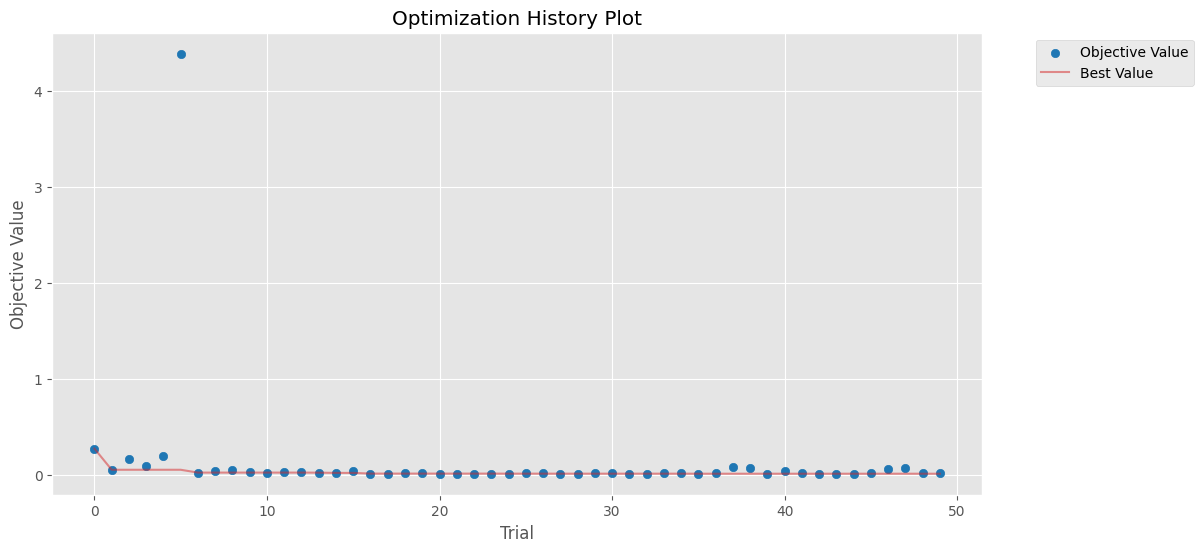

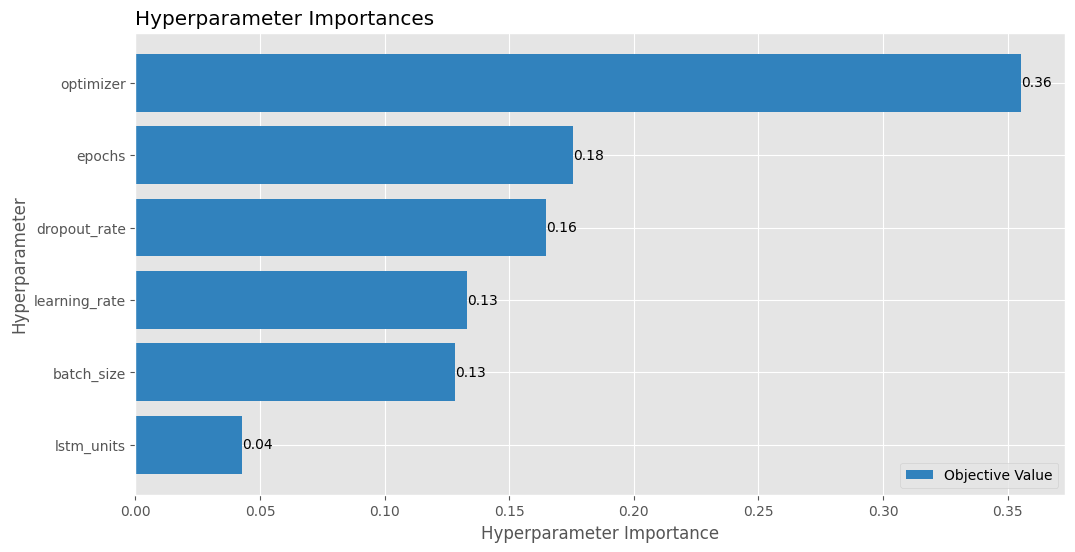

In [21]:
# Plot optimization history and parameter importances
plot_optimization_history(study)
plt.show()
plot_param_importances(study)
plt.show()

In [22]:
# Train final model with best parameters
best_params = study.best_params
model = Sequential([
    LSTM(units=best_params['lstm_units'], input_shape=(X_train.shape[1], 1)),
    Dropout(best_params['dropout_rate']),
    Dense(1)
])

# Select optimizer based on best parameters
if best_params['optimizer'] == 'Adam':
    optimizer = Adam(learning_rate=best_params['learning_rate'])
elif best_params['optimizer'] == 'RMSprop':
    optimizer = RMSprop(learning_rate=best_params['learning_rate'])
else:
    optimizer = SGD(learning_rate=best_params['learning_rate'])

model.compile(optimizer=optimizer, loss='mse')

# Train the model on the full training dataset
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=best_params['epochs'],
                    batch_size=best_params['batch_size'],
                    verbose=1)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.1195 - val_loss: 0.0035
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0396 - val_loss: 0.0133
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0166 - val_loss: 0.0107
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0129 - val_loss: 0.0030
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0138 - val_loss: 0.0108
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0113 - val_loss: 0.0031
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0111 - val_loss: 0.0046
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0093 - val_loss: 0.0035
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0096 - val_loss: 0.0030
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0093 - val_loss: 0.0037
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0097 - val_loss: 0.0031
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0087 - val_loss: 0.0034
E

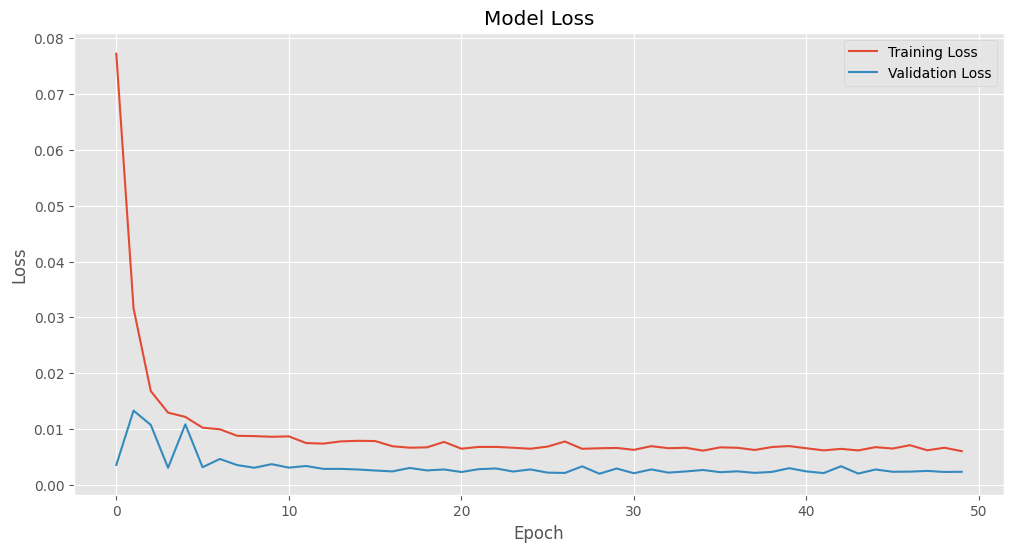

Average Loss: 0.0094


In [23]:
# Fungsi untuk plot training dan validation loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

plot_loss(history)

average_loss = np.mean(history.history['loss'])
print(f"Average Loss: {average_loss:.4f}")

In [24]:
# Make predictions on the training and testing datasets
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [25]:
# Inverse transform predictions and actual values
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

In [26]:
# Define a function to calculate MAE, MAPE, and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.mean(np.abs(errors / actual)) * 100  # Calculate MAPE

    print(model_name + ':')
    print('Mean Absolute Error: {:.3f}'.format(mae))
    print('Root Mean Square Error: {:.3f}'.format(rmse))
    print('Mean Absolute Percentage Error: {:.3f}%'.format(mape))
    print('')

In [27]:
# Evaluasi Model for Training Data
evaluate_prediction(train_predictions, y_train_actual, 'evaluasi model data train')

# Evaluasi Model for Testing Data
evaluate_prediction(test_predictions, y_test_actual, 'evaluasi model data test')

evaluasi model data train:
Mean Absolute Error: 180.914
Root Mean Square Error: 251.626
Mean Absolute Percentage Error: 9.416%

evaluasi model data test:
Mean Absolute Error: 168.820
Root Mean Square Error: 207.625
Mean Absolute Percentage Error: 15.930%



In [28]:
date_train = df['Tanggal'][time_steps:len(y_train_actual) + time_steps]
date_test = df['Tanggal'][-len(y_test_actual):]

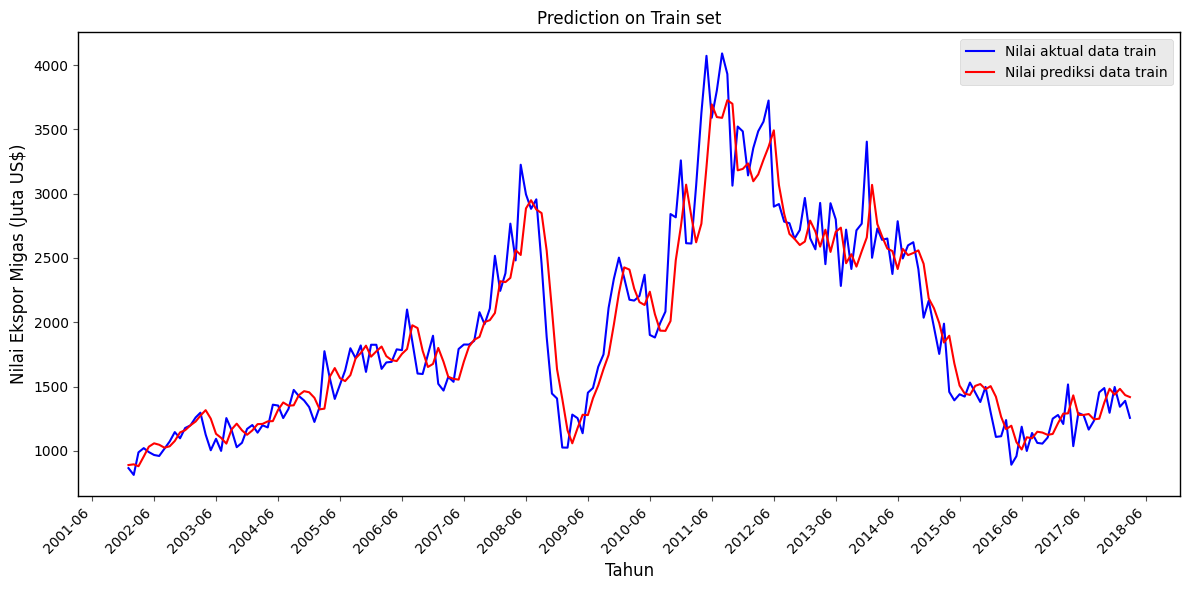

In [29]:
import matplotlib.dates as mdates
# Visualisasi prediksi vs aktual on train data
plt.figure(figsize=(12,6))
plt.title('Prediction on Train set', fontsize=12)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.plot(date_train, y_train_actual, label='Nilai aktual data train', color='blue')
plt.plot(date_train, train_predictions, label='Nilai prediksi data train', color='red')
plt.legend(fontsize=10)
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')

# Mengatur format tanggal
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

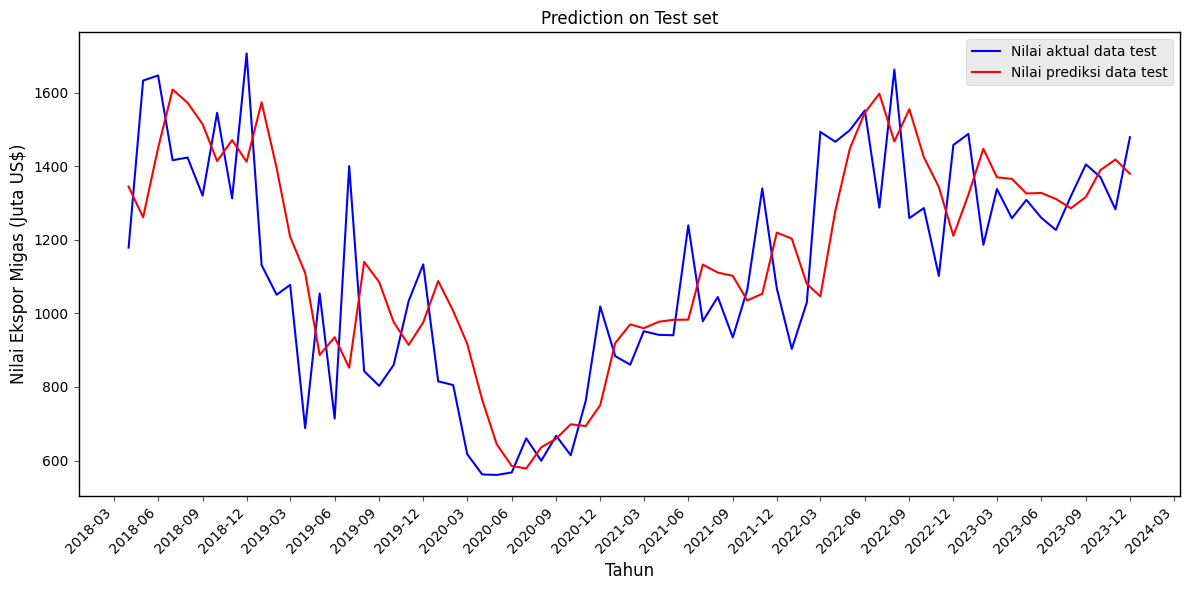

In [30]:
# Visualisasi prediksi vs aktual on test data
plt.figure(figsize=(12,6))
plt.title('Prediction on Test set', fontsize=12)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.plot(date_test, y_test_actual, label='Nilai aktual data test', color='blue')
plt.plot(date_test, test_predictions, label='Nilai prediksi data test', color='red')

# Mengatur format tanggal
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate dates for better visibility
plt.xticks(rotation=45)  # Memutar label x-axis agar lebih mudah dibaca
plt.legend(fontsize=10)
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

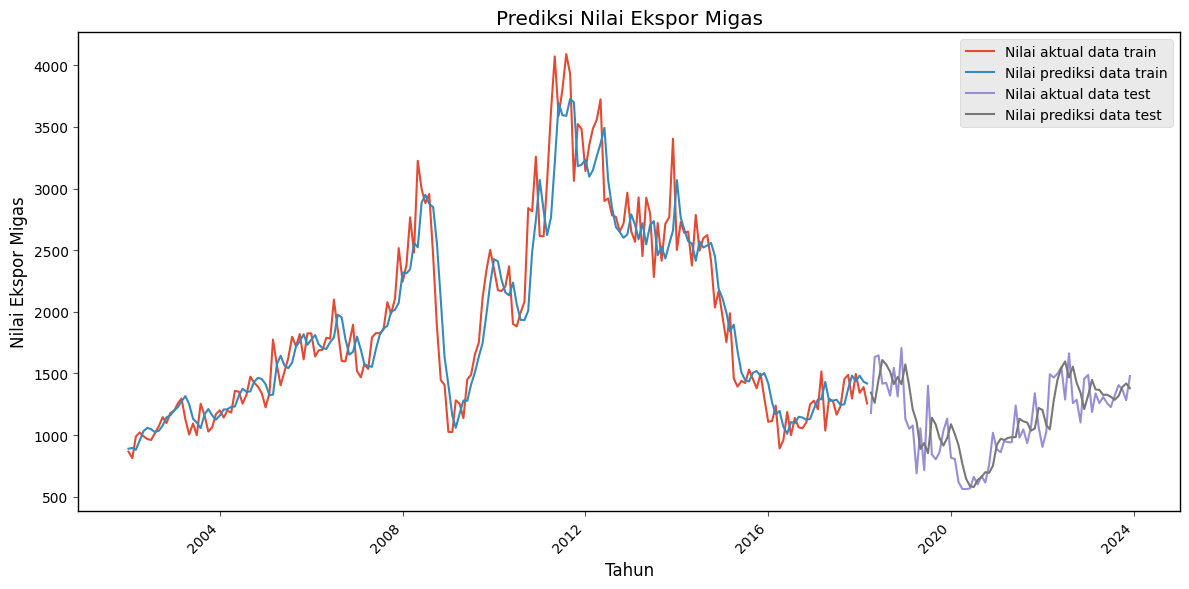

In [31]:
# Plot results
plt.figure(figsize=(12,6))
plt.plot(date_train, y_train_actual, label='Nilai aktual data train')
plt.plot(date_train, train_predictions, label='Nilai prediksi data train')
plt.plot(date_test, y_test_actual, label='Nilai aktual data test')
plt.plot(date_test, test_predictions, label='Nilai prediksi data test')
plt.title('Prediksi Nilai Ekspor Migas')
plt.xlabel('Tahun', color='black')
plt.ylabel('Nilai Ekspor Migas', color='black')
plt.legend(fontsize=10)
plt.legend()
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
      Tanggal  Nilai Ekspor Migas (Peramalan)
0  2024-01-01                     1442.698608
1  2024-02-01                     1471.698242
2  2024-03-01                     1499.143677
3  2024-04-01                     1523.319946
4  2024-05-01                     1545.787109
5  2024-06-01                     1566.741821
6  2024-07-01                     1586.815796
7  2024-08-01                     1606.196899
8  2024-09-01                     1624.742920
9  2024-10-01                     1642.561646
10 2024-11-01                     1659

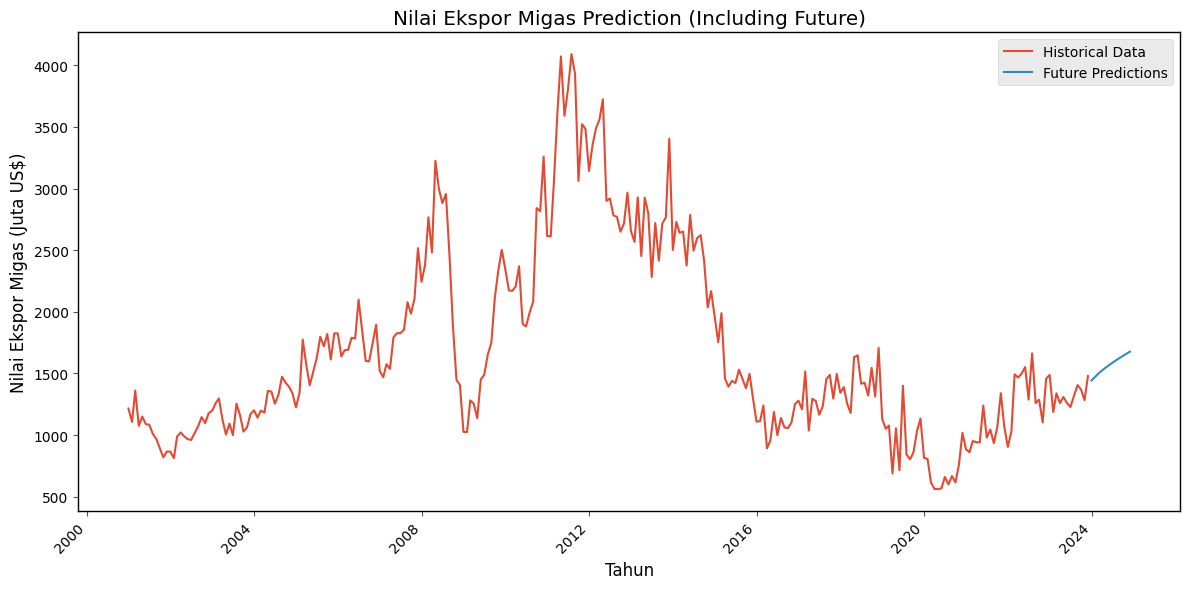

In [32]:
scaled_dt = scaler.fit_transform(dataset)

# Fungsi untuk melakukan peramalan
def forecast_future(model, last_data, periods, scaler):
    future_predictions = []
    current_batch = last_data

    for _ in range(periods):
        # Prediksi satu langkah ke depan
        current_pred = model.predict(current_batch)
        future_predictions.append(current_pred[0])

        # Update batch untuk prediksi berikutnya
        current_batch = np.roll(current_batch, -1, axis=1)
        current_batch[0, -1, 0] = current_pred[0]

    # Inverse transform hasil peramalan
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    return scaler.inverse_transform(future_predictions)

# Ambil data terakhir untuk input peramalan
last_known_data = scaled_dt[-time_steps:]
last_known_data = last_known_data.reshape((1, time_steps, 1))

# Lakukan peramalan untuk 12 periode ke depan
future_periods = 12
future_predictions = forecast_future(model, last_known_data, future_periods, scaler)

# Buat tanggal untuk hasil peramalan
last_date = df['Tanggal'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=30), periods=future_periods, freq='MS')

# Buat DataFrame untuk hasil peramalan
forecast_df = pd.DataFrame({
    'Tanggal': future_dates,
    'Nilai Ekspor Migas (Peramalan)': future_predictions.flatten()
})

print(forecast_df)

# Plot future predictions
plt.figure(figsize=(12,6))
plt.plot(df['Tanggal'], df['Nilai Ekspor Migas'], label='Historical Data')
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.title('Nilai Ekspor Migas Prediction (Including Future)')
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()


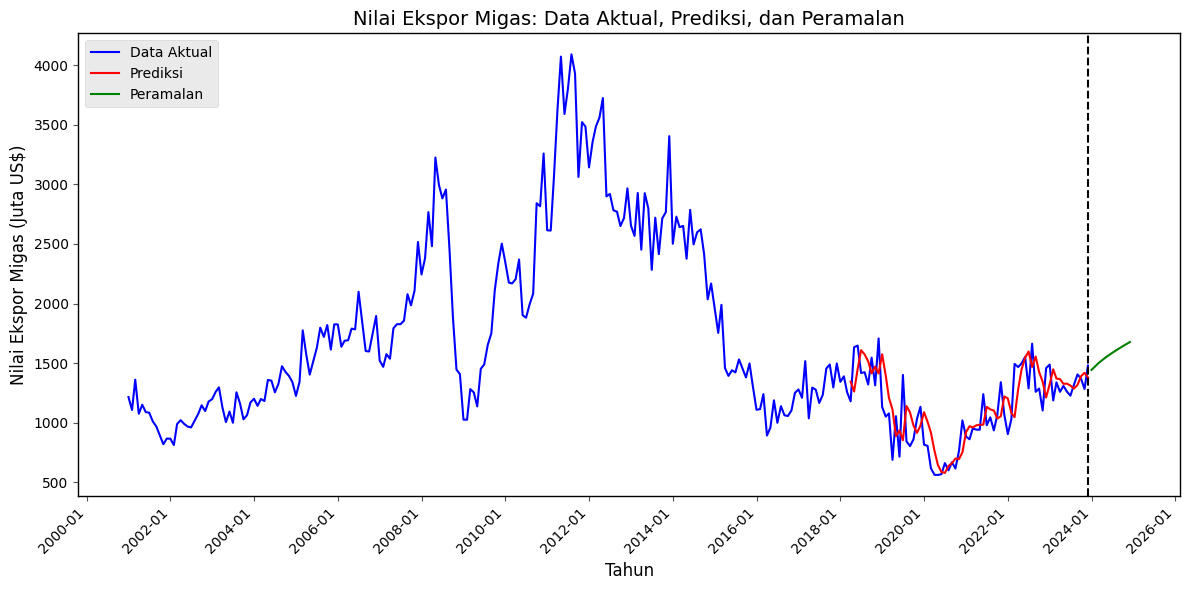

In [33]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Mengubah future_dates menjadi Series
future_dates_series = pd.Series(future_dates)

# Menggabungkan data aktual, prediksi data uji, dan hasil peramalan
all_dates = pd.concat([df['Tanggal'], future_dates_series])
all_actual = pd.concat([df['Nilai Ekspor Migas'], pd.Series([np.nan] * len(future_dates))])
all_predictions = np.concatenate([np.array([np.nan] * (len(df) - len(test_predictions))),
                                  test_predictions.flatten(),
                                  future_predictions.flatten()])

# Membuat plot
plt.figure(figsize=(12, 6))
plt.plot(all_dates, all_actual, label='Data Aktual', color='blue')

# Garis prediksi
plt.plot(all_dates[-len(test_predictions)-len(future_predictions):-len(future_predictions)],
         all_predictions[-len(test_predictions)-len(future_predictions):-len(future_predictions)],
         label='Prediksi', color='red')

# Garis peramalan
plt.plot(all_dates[-len(future_predictions):],
         all_predictions[-len(future_predictions):],
         label='Peramalan', color='green')

# Menambahkan garis vertikal untuk memisahkan data uji dan peramalan
split_date = df['Tanggal'].iloc[-1]
plt.axvline(x=split_date, color='black', linestyle='--')

plt.title('Nilai Ekspor Migas: Data Aktual, Prediksi, dan Peramalan', fontsize=14)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')

# Mengatur format tanggal pada sumbu x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=2))

plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

In [34]:
!pip install openpyxl

In [35]:
forecast_df.to_excel('forecast_75:25_h1t12.xlsx', index=False)
from google.colab import files
files.download('forecast_75:25_h1t12.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
import numpy as np
import pandas as pd

# Konversi y_train_actual, train_predictions, y_test_actual, dan test_predictions ke array satu dimensi
y_train_actual = np.array(y_train_actual).flatten()
train_predictions = np.array(train_predictions).flatten()
y_test_actual = np.array(y_test_actual).flatten()
test_predictions = np.array(test_predictions).flatten()

# Buat DataFrame untuk nilai aktual dan prediksi data train
# Membuat DataFrame hasil untuk training dan testing
train_df = pd.DataFrame({
    'Tanggal': date_train.reset_index(drop=True),
    'Data Aktual': y_train_actual,
    'Data Prediksi': train_predictions
})

# Buat DataFrame untuk nilai aktual dan prediksi data test
test_df = pd.DataFrame({
    'Tanggal': date_test.reset_index(drop=True),
    'Data Aktual': y_test_actual,
    'Data Prediksi': test_predictions
})

# Gabungkan train_df dan test_df menjadi satu DataFrame
prediksi_df = pd.concat([train_df, test_df])

# Simpan DataFrame ke dalam file Excel
prediksi_df.to_excel('prediksi_75:25_h1t12.xlsx', index=False)

# Jika Anda menggunakan Google Colab, Anda dapat mengunduh file Excel
from google.colab import files
files.download('prediksi_75:25_h1t12.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>